In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import random
import pickle


file_list = []
class_list = []

DATADIR = "data"

# All the categories you want your neural network to detect
CATEGORIES = ["Botella", "Lata", "Tetrapak"]

# The size of the images that your neural network will use
IMG_SIZE = 64

# Checking or all images in the data folder
for category in CATEGORIES :
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)

training_data = []

def create_training_data():
    for category in CATEGORIES :
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try :
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()

random.shuffle(training_data)

X = [] #features
y = [] #labels

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Creating the files containing all the information about your model
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

In [2]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Opening the files about data
X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

# normalizing data (a pixel goes from 0 to 255)
X = X/255.0
y = np.array(y)

# Building the model
model = Sequential()
# 3 convolutional layers
model.add(Conv2D(32, (3, 3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 hidden layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))

model.add(Dense(128))
model.add(Activation("relu"))

# The output layer with 3 neurons, for 3 classes
model.add(Dense(len(CATEGORIES)))
model.add(Activation("softmax"))

# Compiling the model using some basic parameters
model.compile(loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

# Training the model, with 40 iterations
# validation_split corresponds to the percentage of images used for the validation phase compared to all the images
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.3)

# Saving the model
model_json = model.to_json()
with open("model.json", "w") as json_file :
	json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

model.save('CNN.model')

Epoch 1/20
53/53 [==============================] - 10s 182ms/step - loss: 1.0477 - accuracy: 0.4226 - val_loss: 0.7438 - val_accuracy: 0.7028
Epoch 2/20
53/53 [==============================] - 11s 200ms/step - loss: 0.6671 - accuracy: 0.6863 - val_loss: 0.4269 - val_accuracy: 0.8139
Epoch 3/20
53/53 [==============================] - 12s 228ms/step - loss: 0.4115 - accuracy: 0.8214 - val_loss: 0.3173 - val_accuracy: 0.8528
Epoch 4/20
53/53 [==============================] - 12s 220ms/step - loss: 0.2394 - accuracy: 0.9095 - val_loss: 0.2511 - val_accuracy: 0.8806
Epoch 5/20
53/53 [==============================] - 8s 158ms/step - loss: 0.1220 - accuracy: 0.9560 - val_loss: 0.1363 - val_accuracy: 0.9431
Epoch 6/20
53/53 [==============================] - 8s 150ms/step - loss: 0.0921 - accuracy: 0.9643 - val_loss: 0.0783 - val_accuracy: 0.9694
Epoch 7/20
53/53 [==============================] - 7s 134ms/step - loss: 0.0791 - accuracy: 0.9679 - val_loss: 0.0634 - val_accuracy: 0.9778
Ep

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


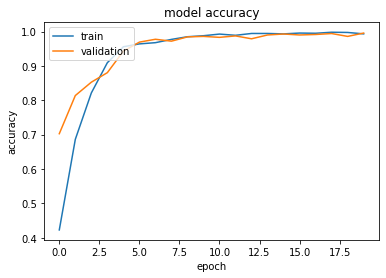

In [3]:
# Printing a graph showing the accuracy changes during the training phase
print(history.history.keys())
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


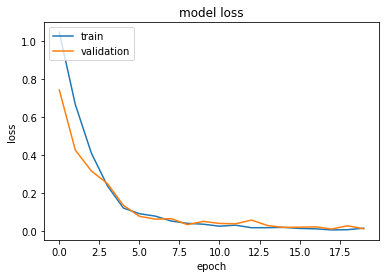

In [4]:
print(history.history.keys())
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [5]:
def decode_onehot(tensor):
    decoded = []
    for prediction in tensor:
        m = 0
        k = 0
        for j in range(len(tensor[0])):
            if prediction[j] > m:
                m = prediction[j]
                k = j
        decoded.append(k)
    return np.array(decoded)

In [6]:
y_pred = decode_onehot(model.predict(X_test))

In [7]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [8]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalized=True,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalized:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Matriz de confusion normalizada'
        fmt = '.2f'
    else:
        title='Matriz de confusion no normalizada'
        fmt = 'd'
        
    plt.figure(figsize=(8, 6), dpi=90)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid('off')
    plt.tight_layout()

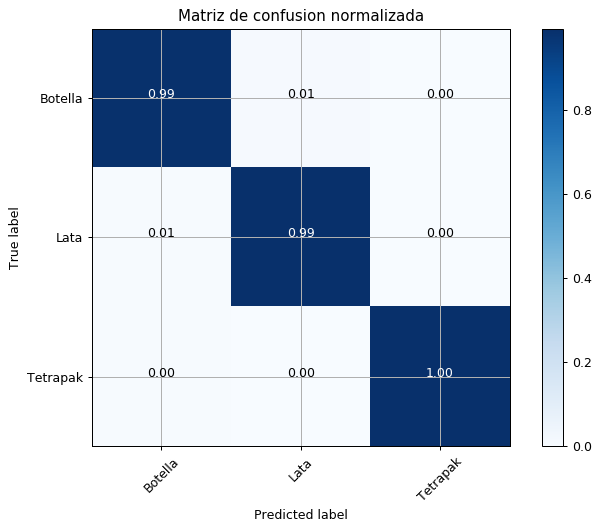

In [9]:
plot_confusion_matrix(cm, CATEGORIES, normalized=True)

In [10]:
X_test[0].shape

(64, 64, 1)

In [24]:
def show_img_results(classifier, X, y, i, j): # Toma n imagenes, las muestra con su clase verdadera y predecida.
    for k in range(j-i):
        print(i+k)
        img = X[i+k]
        gold = y[i+k]
        print('Clase Real: ', gold)
        prob = classifier.predict(np.array([X[i+k]]))
        pred = decode_onehot(prob)[0]
        print('Clase Predicha. ', pred)
        print('Probabilidad Clase: ', prob)
        plt.figure()
        plt.imshow(img.squeeze())
        plt.show()

193
Clase Real:  1
Clase Predicha.  1
Probabilidad Clase:  [[1.2051622e-06 9.9966466e-01 3.3410295e-04]]


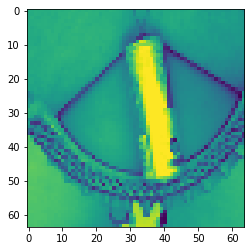

194
Clase Real:  1
Clase Predicha.  1
Probabilidad Clase:  [[1.1190720e-06 9.9999595e-01 2.9636356e-06]]


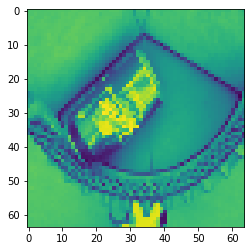

195
Clase Real:  1
Clase Predicha.  1
Probabilidad Clase:  [[1.4313447e-06 9.9979931e-01 1.9928410e-04]]


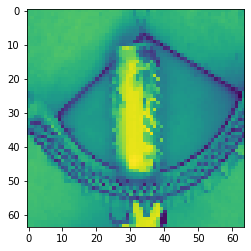

196
Clase Real:  1
Clase Predicha.  1
Probabilidad Clase:  [[9.8195130e-07 9.9999702e-01 1.9724362e-06]]


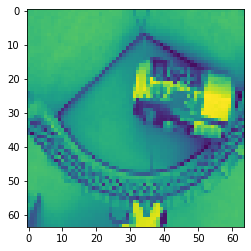

197
Clase Real:  1
Clase Predicha.  1
Probabilidad Clase:  [[3.4555095e-10 1.0000000e+00 7.3830915e-09]]


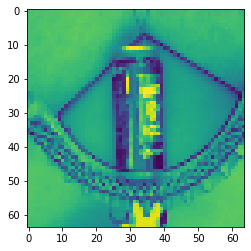

198
Clase Real:  2
Clase Predicha.  2
Probabilidad Clase:  [[3.4219411e-06 6.3315548e-07 9.9999595e-01]]


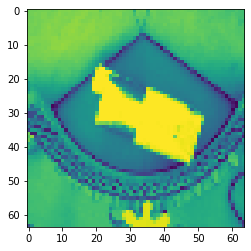

199
Clase Real:  0
Clase Predicha.  0
Probabilidad Clase:  [[9.9998748e-01 2.1707974e-06 1.0336700e-05]]


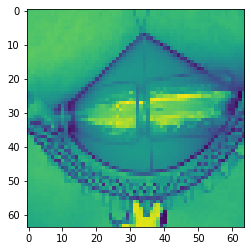

In [25]:
show_img_results(model, X_test, y_test, 193, 200)

320
Clase Real:  0
Clase Predicha.  0


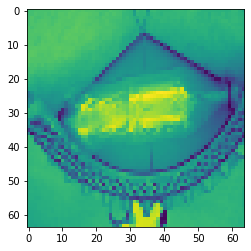

321
Clase Real:  1
Clase Predicha.  1


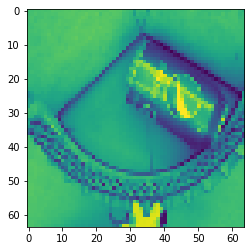

322
Clase Real:  2
Clase Predicha.  2


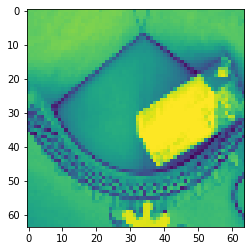

323
Clase Real:  2
Clase Predicha.  2


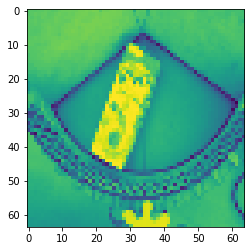

324
Clase Real:  0
Clase Predicha.  0


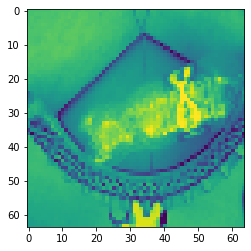

In [19]:
show_img_results(model, X_test, y_test, 320, 325)

In [20]:
def show_misclassifications(classifier, Data, label):
    for i in range(len(Data)):
        gold = y[i]
        prob = classifier.predict(np.array([X[i]]))
        pred = decode_onehot(prob)[0]
        if gold != pred:
            print(i)
            print('Clase Real: ', gold)
            print('Clase Predicha: ', pred)
            print('Probabilidad Clase: ', prob)
            img = X[i]
            plt.figure()
            plt.imshow(img.squeeze())
            plt.show()

197
Clase Real:  0
Clase Predicha:  1
Probabilidad Clase:  [[0.00279351 0.6427589  0.35444757]]


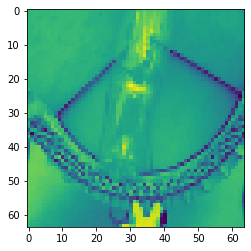

323
Clase Real:  2
Clase Predicha:  0
Probabilidad Clase:  [[0.65818954 0.13782962 0.20398083]]


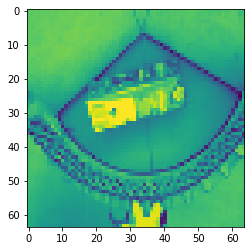

In [21]:
show_misclassifications(model, X_test, y_test)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 29, 29, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        3

conv2d (3, 3, 1, 32)


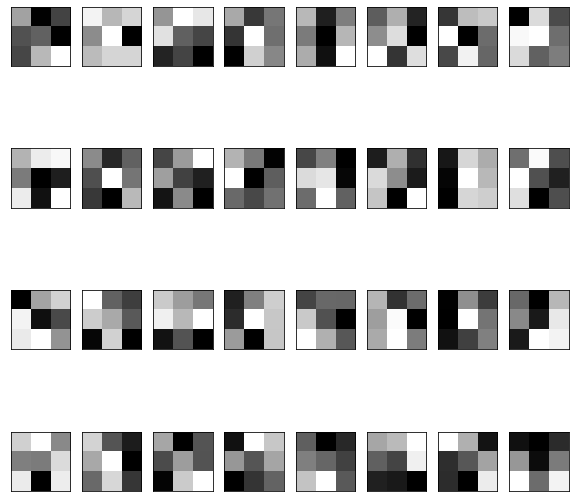

conv2d_1 (3, 3, 32, 64)


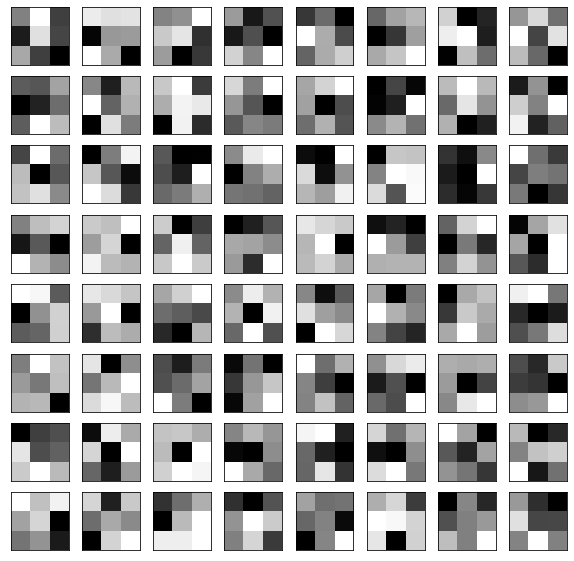

conv2d_2 (3, 3, 64, 64)


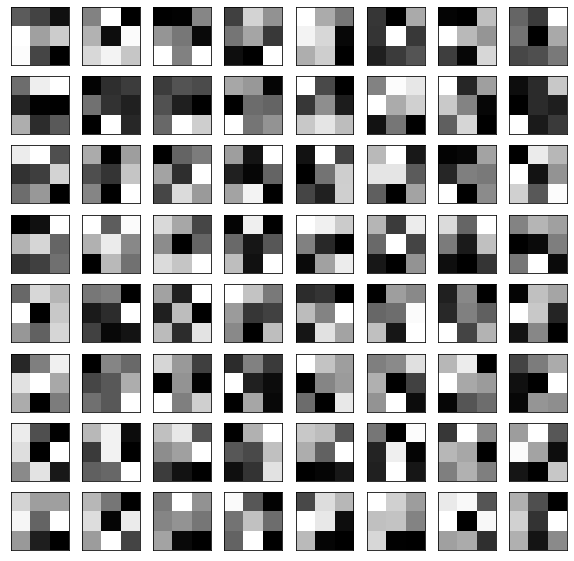

In [62]:
for layer in model.layers:
    if 'conv' not in layer.name:
        continue
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)
    n_filters = filters.shape[3]
    fig, ax = plt.subplots(figsize=(10, 10))
    for i in range(int(n_filters)):
        f = filters[:,:,0,i]
        ax = plt.subplot(int(n_filters/8), 8, i+1)
        plt.imshow(f, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()